In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../code')
from python.commons import full_inference_e2e, inc_inference_e2e, adaptive_drilldown, generate_heatmap
from python.imagenet_classes import class_names
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

image_file_path = "../code/python/dog_resized.jpg"

In [2]:
torch.set_num_threads(8)

In [3]:
model = VGG16
patch_size = 16
stride = 4
dataset = 'ImageNet'

show = True
    
if model == Inception3:
    image_size = 299
    x_size = 299
    y_size = 299
else:
    image_size = 224
    x_size = 224
    y_size = 224

In [4]:
torch.cuda.synchronize()
prev_time = time.time()
with torch.no_grad():
    x, prob, logit_index = full_inference_e2e(model, image_file_path, patch_size, stride, batch_size=128, gpu=True, image_size=image_size, x_size=x_size, y_size=y_size)

torch.cuda.synchronize()
full_inference_gpu_time = time.time() - prev_time

# torch.cuda.synchronize()
# prev_time = time.time()
# with torch.no_grad():
#     x, prob, logit_index = full_inference_e2e(model, image_file_path, patch_size, stride,
#                            batch_size=16, gpu=False, image_size=image_size, x_size=x_size, y_size=y_size)

# torch.cuda.synchronize()
# full_inference_cpu_time = time.time() - prev_time


print("Full Inference GPU Time: " + str(full_inference_gpu_time))
# print("Full Inference CPU Time: " + str(full_inference_cpu_time))

Full Inference GPU Time: 7.30693387985


/home/snakanda/.local/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


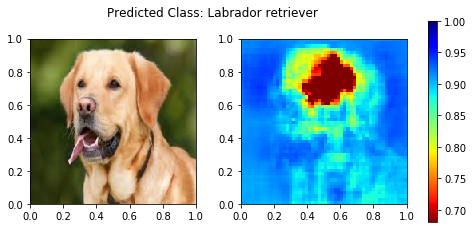

In [5]:
orig_hm = generate_heatmap(image_file_path, x, show=show, label=class_names[logit_index], prob=prob, width=image_size)

output = open('temp', 'w')
pickle.dump(orig_hm, output)
output.close()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False, gpu=True, version='v1'):
    #model specific configurations
    if gpu:
        batch_size = 256
    else:
        batch_size = 16
        
    if gpu:
        torch.cuda.synchronize()
    
    if not adaptive:
        with torch.no_grad():
            x, prob, logit_index = inc_inference_e2e(model, image_file_path, patch_size, stride,
                                  batch_size=batch_size, beta=beta, gpu=gpu, version=version,
                                 image_size=image_size, x_size=x_size, y_size=y_size)
    else:
        with torch.no_grad():
            x, prob, logit_index = adaptive_drilldown(model, image_file_path, patch_size, stride,
                                    batch_size=batch_size, beta=beta, percentile=20)
    if gpu:
        torch.cuda.synchronize()

    return x, prob, logit_index

In [ ]:
orig_hm = pickle.load(open('temp', 'r'))

times_gpu_custom = []
speedups_gpu_custom = []
score_gpu_custom = []

times_gpu = []
speedups_gpu = []

times_cpu = []
speedups_cpu = []
score_cpu = []

taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

for beta in taus:    
    #CPU
    prev_time = time.time()
    x, prob, logit_index = inc_inference(beta, patch_size=patch_size, stride=stride, gpu=False, version='v2')
    inc_inference_time = time.time()-prev_time
    times_cpu.append(inc_inference_time)
    speedups_cpu.append(full_inference_cpu_time/inc_inference_time)
    
    label = "CPU - BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=show, label=class_names[logit_index], prob=prob,
                          width=image_size)

    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None

    score_cpu.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))
    
    #GPU
    prev_time = time.time()
    x, prob, logit_index = inc_inference(beta, patch_size=patch_size, stride=stride, gpu=True, version='v2')
    inc_inference_time = time.time()-prev_time
    times_gpu.append(inc_inference_time)
    speedups_gpu.append(full_inference_gpu_time/inc_inference_time)
    
    #GPU Custom
    prev_time = time.time()
    x, prob, logit_index = inc_inference(beta, patch_size=patch_size, stride=stride, gpu=True, version='v1')
    inc_inference_time = time.time()-prev_time
    times_gpu_custom.append(inc_inference_time)
    speedups_gpu_custom.append(full_inference_gpu_time/inc_inference_time)
    label = "GPU Custom - BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=show, label=class_names[logit_index], prob=prob, width=image_size)
    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None
    score_gpu_custom.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))

In [ ]:
fig = plt.figure(figsize=(4,2))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(taus, score_cpu, marker='x', color='tab:orange')
ax1.plot(taus, score_gpu_custom, marker='o', color='tab:blue')
ax1.grid()
#ax1.set_xlabel(r'$\tau$')
#ax1.set_ylabel('SSIM', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.xaxis.set_ticks(np.arange(0.4, 1.1, 0.1))

ax2 = ax1.twinx()
ax2.plot(taus, speedups_cpu, marker='D', color='tab:red', label='CPU')
ax2.plot(taus, speedups_gpu, marker='^', color='tab:red', label='GPU')
ax2.plot(taus, speedups_gpu_custom, marker='s', color='tab:red', label='GPU Custom')
#ax2.set_ylabel('Speedup', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

#fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.025), frameon=False)
fig.tight_layout()
fig_label = str(model).split('.')[-1][:-2]+"/"+str(dataset)+"/P="+str(patch_size)+"/S="+str(stride)
fig.suptitle(fig_label, y=1.05, x=0.53)
plt.savefig('./plots/'+fig_label.replace('/','-')+'.jpg')

In [ ]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

for beta in [1.0, 0.7, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2]:
    prev_time = time.time()
    x, prob, logit_index = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, label=class_names[logit_index], prob=prob)
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True))

In [ ]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('SSIM')